# Processing the altimetry data
- preparation for the Gaussian Mixture Model (GMM), which will be used to find regions of coherent sea level variability
- **Input:**
    - monthly mean altimetry data set from 1994 to 2022 (first and last year not full) for the region of interest (area preselected with e.g. CDO); NetCDF format
    - from folder s00_Original
- **Output:**
    - **Data:** monthly mean altimetry data set with interpolated small gaps and for the selected time span and removed seasonal cycle; sea level, longitude, latitude, and time, saved as separate .npy files and in a .mat (MATLAB formatted data) file
    - **Figures:** number of missing data per grid point, number of grid points with missing data per time step, deseasoned time series for 6 randomly selected grid points, seasonal cycle for 6 randomly selected grid points (not same grid points)
    - saved to s01_Processed
- **Steps:**
    - load and extract the data
    - find and plot the number of missing values in the data set
    - interpolate the missing data (1D interpolation in time dimension) for grid points with less than 40% time steps missing
    - select the desired time span (full years only)
    - remove the seasonal cycle

Author: Lea Poropat <br>
Last edited: 2023-12-07

### <font color = "red">Parameters</font>

In [1]:
# start and end year of the selected time span
y1 = 1995
y2 = 2021

# region, because the script needs to be re-run for all of them
reg = 'NWeuropeSeas'

# input and output files
filein = r'../Data/s00_Original/altimetry_M-m_1994_2022_' + reg + '.nc'
fileout = r'../Data/s01_Processed/altimetry_M_' + str(y1) + '_' + str(y2) + '_' + reg + '_'
figs = r'../Figures/s01_Processed/' # folder for figures
fig1 = figs + reg + '_' + str(y1) + '_' + str(y2) + '_gaps_spatial.png'
fig2 = figs + reg + '_' + str(y1) + '_' + str(y2) + '_gaps_temporal.png'
fig3 = figs + reg + '_' + str(y1) + '_' + str(y2) + '_deseasoning.png'
fig4 = figs + reg + '_' + str(y1) + '_' + str(y2) + '_deseasoning_cycle.png'

### Import the libraries

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import savemat
import eofs.standard as es
from random import randint

### Loading the dataset and extracting data

In [3]:
# loading the data
ds=nc.Dataset(filein)
x=ds['sla'][:]
lon = np.array(ds['longitude'][:])
lat = np.array(ds['latitude'][:])
time = nc.num2date(ds['time'][:], ds['time'].units)

# data shape
print('--- Original data:')
print('Longitude shape:    %s' % str(np.shape(lon)))
print('Latitude shape:     %s' % str(np.shape(lat)))
print('Data shape:         %s' % str(np.shape(x)))
print('Start and end date: %s - %s' % (str(time[0]), str(time[-1])))
nt0, nlat, nlon = np.shape(x)

--- Original data:
Longitude shape:    (160,)
Latitude shape:     (100,)
Data shape:         (343, 100, 160)
Start and end date: 1994-01-15 00:00:00 - 2022-07-15 00:00:00


In [4]:
# converting the time array
year0 = np.empty(np.shape(time), np.int16)
month0 = np.empty(np.shape(time), np.int16)
for i in range(len(time)):
    temp = str(time[i])
    year0[i] = int(temp[0:4])
    month0[i] = int(temp[5:7])
t0 = year0 + (month0-1.0)/12

In [5]:
# creating a lon-lat meshgrid (to have lon-lat pairs corresponding to each grid point)
Lat, Lon = np.meshgrid(lat, lon, indexing = 'ij')
print('--- Meshgrid:')
print('Lon mesh shape:  %s' % str(np.shape(Lon)))
print('Lat mesh shape:  %s' % str(np.shape(Lat)))

--- Meshgrid:
Lon mesh shape:  (100, 160)
Lat mesh shape:  (100, 160)


### Find and plot the number of missing values in the original data set

In [6]:
# finding the number of missing time steps per grid point
mask = ma.getmask(x)
missing_grid = np.count_nonzero(mask, axis = 0)


# finding the data coverage per time step
gaps = (missing_grid >= 1) & (missing_grid < nt0)       # finding the gaps (sea grid point with missing data)
number_of_gaps = np.count_nonzero(gaps)        # number of grid points with missing data (that are not land)

p = 0  # grid point index
data_coverage = np.empty((number_of_gaps, nt0))   # mask, but with 0/1 for easier plotting
for i in range(nlon):
    for j in range(nlat):
        if gaps[j, i]:
            data_coverage[p, :] = mask[:, j, i]
            p = p+1

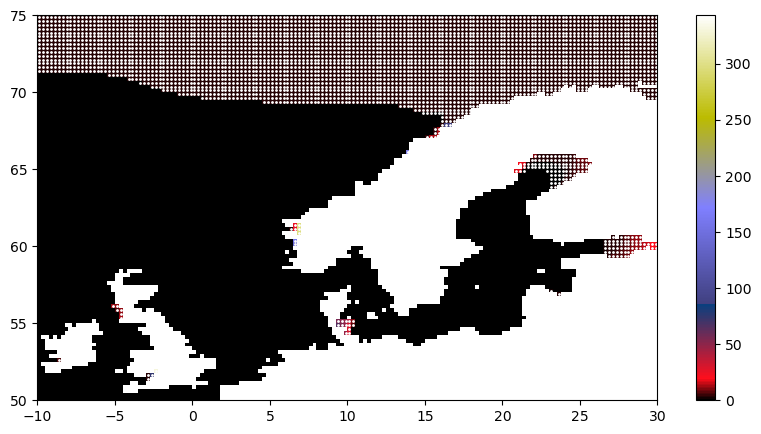

In [7]:
# plotting the number of missing time steps per grid point + marking all grid points that have missing data with dots
# for the data that will be kept after interpolation
#plt.rcParams['figure.figsize'] = [14, 10]
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
cmap = plt.get_cmap('gist_stern')
plt.pcolormesh(Lon, Lat, missing_grid, shading = 'nearest', cmap = cmap)
plt.colorbar()
plt.scatter(Lon[gaps], Lat[gaps], 1, 'white');
fig.savefig(fig1)

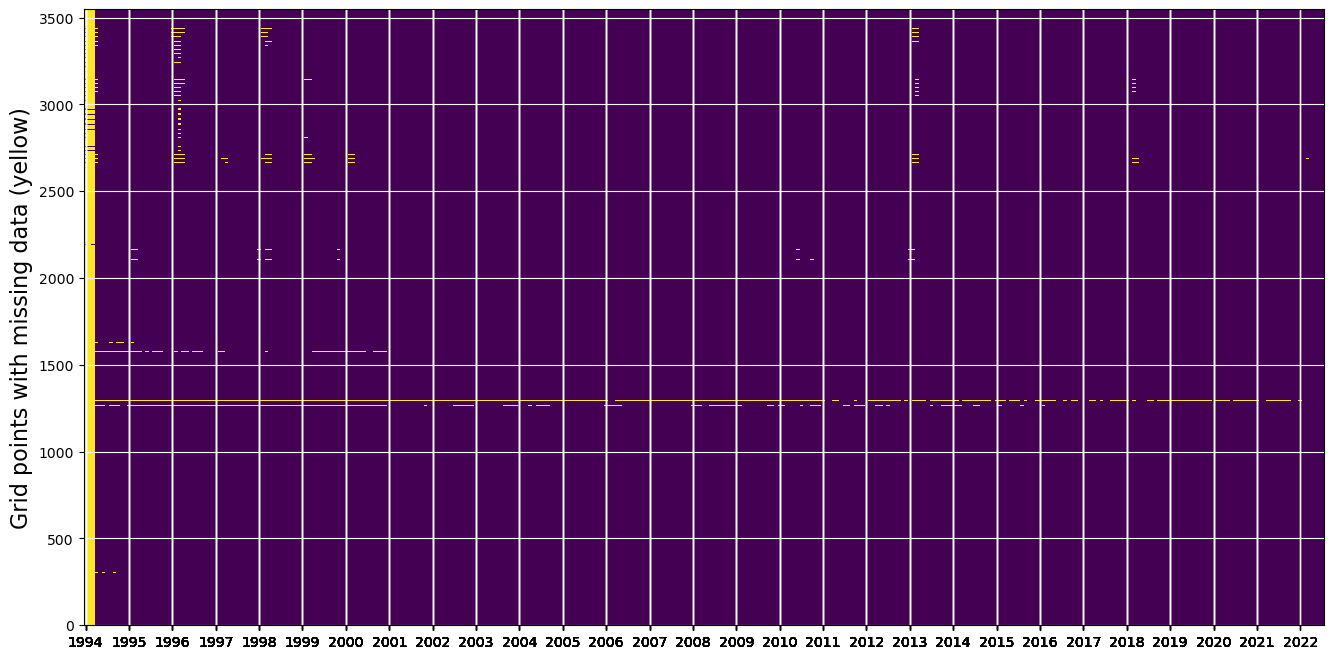

In [8]:
# plotting the time dependence of the missing points for the ocean data
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
            
plt.pcolormesh(t0, np.arange(number_of_gaps), data_coverage[:, :], shading = 'nearest')
plt.xticks(ticks = year0)
plt.grid(color = 'w')
plt.ylabel('Grid points with missing data (yellow)', fontsize = 16);
fig.savefig(fig2)

### Mask the mostly missing grid points (coastal/rivers)

In [9]:
mask2 = np.copy(mask)

for i in range(nlat):
    for j in range(nlon):
         if ((missing_grid[i, j] >= nt0/3) & (missing_grid[i, j] < nt0)):
                mask2[:, i, j] = np.full((nt0,), True, dtype = bool)
                
x2 = ma.array(x, mask = mask2)
x2.filled(np.nan);

### Filling the gaps

It is easier to do it with pandas, so I remove the gaps that won't be interpolated, reshape into 2D, interpolate, remove the remaining NaNs and convert back to grid.

In [10]:
# reshaping the dataset
x2r = np.reshape(x2,(nt0,-1),'C') # 2 (removed grid points with a lot of missing data) r (reshaped to 2D)
Lonr = np.reshape(Lon, -1, 'C')
Latr = np.reshape(Lat, -1, 'C')
n_all = np.shape(x2r)[1]

# converting to a dataframe
data = pd.DataFrame(x2r.transpose())

# filling the gaps
data_interp = data.interpolate(method = 'linear', axis = 1)

# convert back to numpy
x2ri = data_interp.values # 2 (removed almost empty grid points) r (reshaped to 2D) i (interpolated)

# removing start and end of the time series (with gaps that cannot be interpolated)
ind = (year0 >= y1) & (year0 <= y2)
x3r = x2ri[:, ind]        # 3 (removed almost empty grid points + edges in time) r (reshaped to 2D)
data_coverage = data_coverage[:, ind] # same for the data_coverage variable (needed later)
t = t0[ind]
year = year0[ind]
month = month0[ind]
nt = len(t)
ny = max(year) - min(year) + 1

In [11]:
# checking if there are any gaps left in the data set (that are not land points, i.e. always nan)
# each grid point time series needs to be either completely full or completely empty
n_remaining_gaps = 0
for i in range(n_all):
    numnan = np.sum(np.isnan(x3r[i, :]))
    if (numnan > 0 | numnan < nt):
        n_remaining_gaps = n_remaining_gaps + 1
print('The number of remaining grid points with missing some time steps: %2i'% n_remaining_gaps)

The number of remaining grid points with missing some time steps:  0


### <font color = "red">Used data set timespan</font>

In [12]:
print('The processed data set contains')
print('%4i - %4i -> %2i years (%3i time steps)' % (np.floor(year[0]), np.floor(year[-1]), year[-1]-year[1]+1, nt))

The processed data set contains
1995 - 2021 -> 27 years (324 time steps)


### Removing the seasonal cycle

In [13]:
# calculating the seasonal cycle
seasonal_cycle = np.empty((np.shape(x3r)[0], 12))
seasonal_var = np.empty((np.shape(x3r)[0], 12))

for i in range(1, 13):
    seasonal_cycle[:, i-1] = np.mean(x3r[:, month == i], axis = 1)
    seasonal_var[:, i-1] = np.std(x3r[:, month == i], axis = 1)
    
# concat the cycle to the same size as the data
sc = seasonal_cycle[:,:]
sv = seasonal_var[:,:]
for i in range(1, ny):
    sc = np.concatenate((sc, seasonal_cycle), axis = 1)
    sv = np.concatenate((sv, seasonal_var), axis = 1)
    
# removing the seasonal cycle
x3rds = x3r - sc
x3rds2 = x3rds/sv   # 3 (removed large gaps, ends of series) r (reshaped to 2D) ds (deseasoned) 2 (seasonal var removed too)

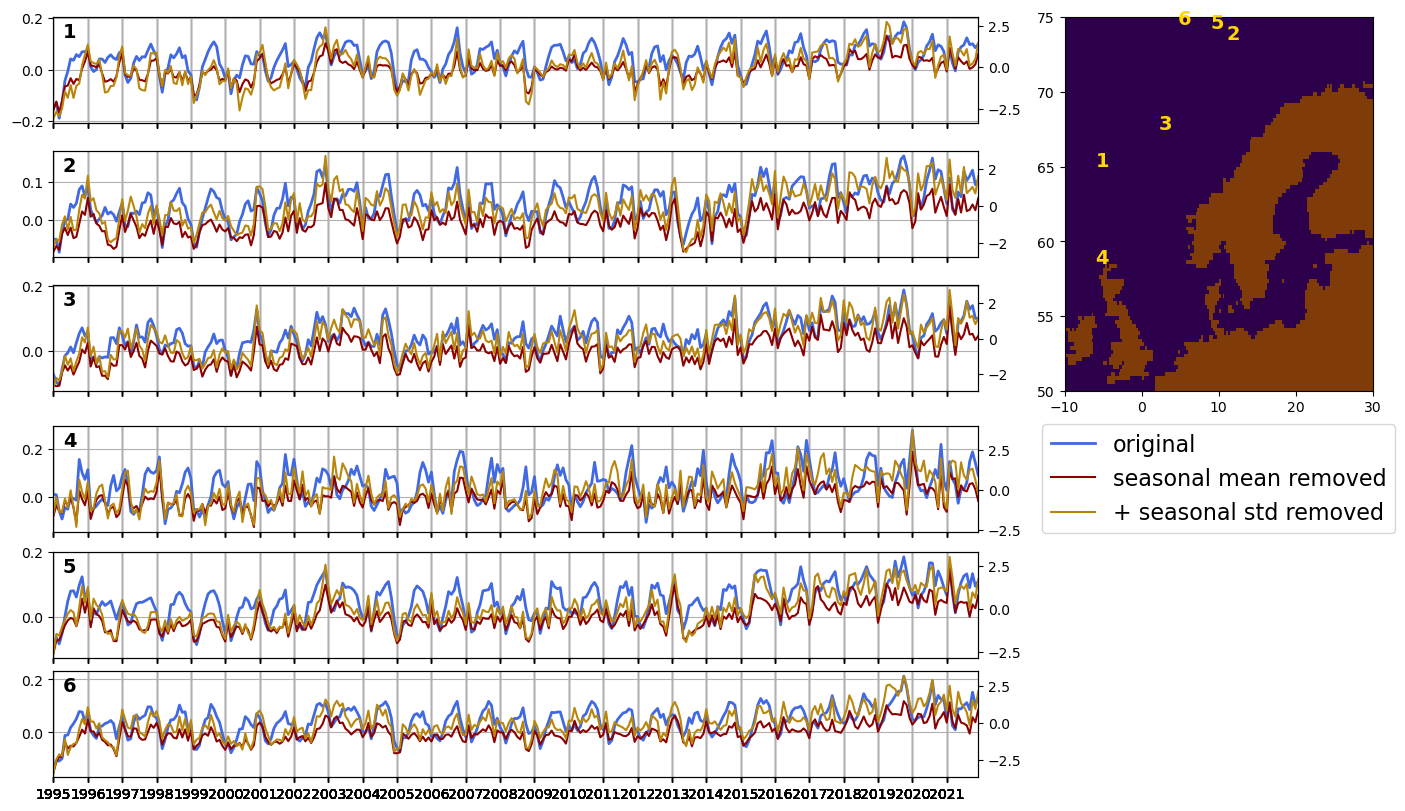

In [14]:
# plotting examples of deseasoned time series (random)
num_plotted = 6   # number of time series to be plotted
plotted = np.empty((num_plotted), np.int16)  # list of indices that are plotted (to be filled while plotting)
mosaic = []
for i in range(num_plotted):
    if i <= 1/2*num_plotted-1:
        mosaic.append([str(i), 'map'])
    elif i <= 1/2*num_plotted:
        mosaic.append([str(i), 'legend'])
    else:
        mosaic.append([str(i), '.'])

# figure size and creating the subplots
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplot_mosaic(mosaic, gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)

# plotting the random time series
i = 0  # number of plot done
while i < num_plotted:
    j = randint(0, np.shape(x3r)[0]-1)   # a random index withing X
    
    if np.any(np.isnan(x3r[j, :])):
        # skip if the random index is a land point
        continue
    elif j in plotted:
        # skip if the random index was already chosen
        continue
    else:
        # plotting
        p1, = ax[str(i)].plot(t, x3r[j, :], 'royalblue', linewidth = 2, label = 'original')
        p2, = ax[str(i)].plot(t, x3rds[j, :], 'darkred', label = 'seasonal mean removed')
        ax[str(i)].set_xlim([t[0], t[-1]])
        ax1 = ax[str(i)].twinx()
        p3, = ax1.plot(t, x3rds2[j, :], 'darkgoldenrod', label = '+ seasonal std removed')
        ax1.set_xlim(t[0], t[-1])
        
        # time series number on the plot
        ax[str(i)].text(0.01, 0.95, str(i+1), ha = 'left', va = 'top', fontsize = 14, transform=ax[str(i)].transAxes, \
                        fontweight = 'bold')
        
        # setting the ticks for January every year and grid
        ax[str(i)].axes.xaxis.set_ticks(year)
        ax[str(i)].grid('on')
        
        
        # removing the x tick labels for all but the lowest plot
        if i < num_plotted-1:
            ax[str(i)].axes.xaxis.set_ticklabels([])
        else:
            ax[str(i)].axes.xaxis.set_ticklabels(year)
        
        
        # saving the index of the plotted series
        plotted[i] = j
        
        # counting the plotted series
        i = i+1
        
# plotting the map
landmask = missing_grid < nt0

ax['map'].pcolormesh(Lon, Lat, landmask, shading = 'nearest', cmap = 'PuOr')
for i in range(num_plotted):
    ax['map'].text(Lonr[plotted[i]], Latr[plotted[i]], str(i+1), ha = 'center', va = 'center', fontsize = 14, \
                   color = 'gold', fontweight = 'bold')

# adding the legend for different time series
ax['legend'].legend([p1, p2, p3], ['original', 'seasonal mean removed', '+ seasonal std removed'], loc = 'center', \
                    fontsize = 16)
ax['legend'].axis('off')

plt.show()
fig.savefig(fig3)

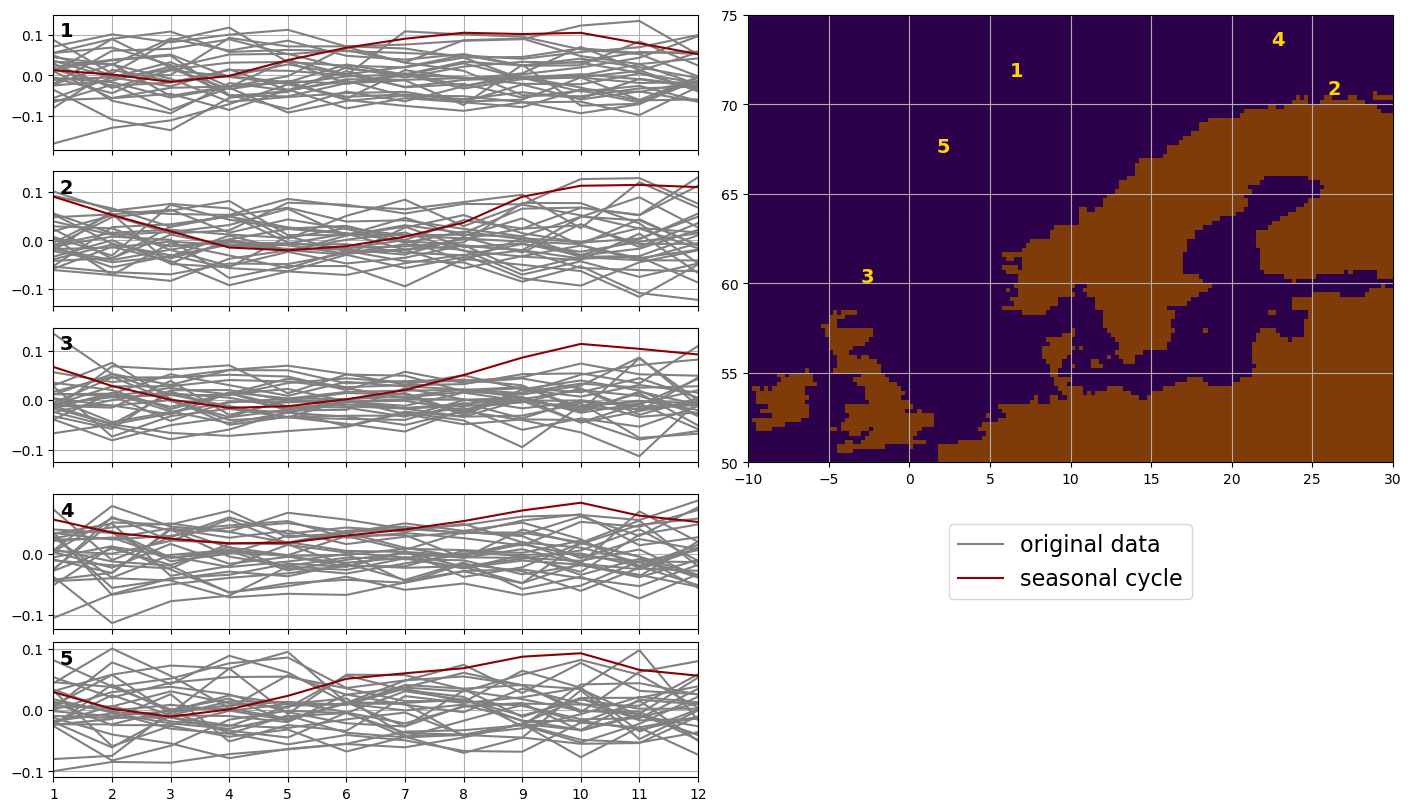

In [15]:
# plotting examples of the seasonal cycle (random)
num_plotted = 5   # number of time series to be plotted
plotted = np.empty((num_plotted), np.int16)  # list of indices that are plotted (to be filled while plotting)
mosaic = []
for i in range(num_plotted):
    if i <= 3/4*num_plotted-1:
        mosaic.append([str(i), 'map'])
    elif i <= 3/4*num_plotted:
        mosaic.append([str(i), 'legend'])
    else:
        mosaic.append([str(i), '.'])

# figure size and creating the subplots
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplot_mosaic(mosaic, gridspec_kw={'width_ratios': [1, 1]}, constrained_layout=True)

# plotting the random time series
i = 0  # number of plot done
while i < num_plotted:
    j = randint(0, np.shape(x3rds)[0]-1)   # a random index withing X
    
    if np.any(np.isnan(x3rds[j, :])):
        # skip if the random index is a land point
        continue
    elif j in plotted:
        # skip if the random index was already chosen
        continue
    else:
        # plotting
        for y in range(year[0], year[-1]+1):
            ind = (year == y)
            p1, = ax[str(i)].plot(range(1, 13), x3rds[j, ind], 'grey')
        p2, = ax[str(i)].plot(range(1, 13), seasonal_cycle[j, :], 'darkred')
        
        # time series number on the plot
        ax[str(i)].text(0.01, 0.95, str(i+1), ha = 'left', va = 'top', fontsize = 14, transform=ax[str(i)].transAxes, \
                        fontweight = 'bold')
        
        # setting the ticks for each month
        ax[str(i)].set_xlim([1, 12])
        ax[str(i)].axes.xaxis.set_ticks(month[0:12])
        ax[str(i)].grid('on')
        
        
        # removing the x tick labels for all but the lowest plot
        if i < num_plotted-1:
            ax[str(i)].axes.xaxis.set_ticklabels([])
        else:
            ax[str(i)].axes.xaxis.set_ticklabels(month[0:12])
        
        
        # saving the index of the plotted series
        plotted[i] = j
        
        # counting the plotted series
        i = i+1
        
# plotting the map
landmask = missing_grid < nt0

ax['map'].pcolormesh(Lon, Lat, landmask, shading = 'nearest', cmap = 'PuOr')
ax['map'].grid('on')
for i in range(num_plotted):
    ax['map'].text(Lonr[plotted[i]], Latr[plotted[i]], str(i+1), ha = 'center', va = 'center', fontsize = 14, \
                   color = 'gold', fontweight = 'bold')

# adding the legend for different time series
ax['legend'].legend([p1, p2], ['original data', 'seasonal cycle'], loc = 'center', fontsize = 16)
ax['legend'].axis('off')

plt.show()
fig.savefig(fig4)

### Convert back to grid

In [16]:
# converting back to 3D grid
x3ds2 = np.reshape(x3rds2.transpose(),(nt, nlat, nlon),'C')

### Saving the processed data

In [17]:
# longitude and latitude
np.save(fileout + 'Lon.npy', Lon, allow_pickle = False)
np.save(fileout + 'Lat.npy', Lat, allow_pickle = False)
np.save(fileout + 'time.npy', t, allow_pickle = False)

# processed data
np.save(fileout + 'interpolated_deseasoned.npy', x3ds2, allow_pickle = False)

# missing data (saved for matlab)
savemat(fileout + 'missing_grid.mat', dict(lon = lon, lat = lat, t = t, space = missing_grid))